
<center><font size=10>Capstone Project:</center></font>
<center><font size=6> Sentiment Analysis on IMDB 50K Movie Reviews Using Multiple Text Embedding Techniques</center></font>

# **Context**


Online movie reviews play a significant role in shaping audience opinions and influencing viewing decisions. These reviews often contain diverse opinions expressed in natural language, making them valuable for sentiment analysis. This capstone project focuses on applying Natural Language Processing (NLP) techniques to automatically classify movie reviews from the IMDB 50K dataset as positive or negative, enabling a deeper understanding of public sentiment toward films.

# **Problem Statement**


The goal of this project is to build an effective machine learning model that can accurately classify movie reviews as positive or negative. This requires proper text preprocessing, embedding selection, model building, and performance evaluation on the IMDB 50K dataset.

## Objective

* Build a sentiment classification model using the IMDB 50K Movie Reviews dataset.
* Apply multiple text embedding techniques (BoW, TF-IDF, Word2Vec, GloVe, BERT).
* Compare the performance of these embeddings for accurate sentiment prediction.
* Understand how different text representations impact model accuracy and overall performance.



# Installing and Importing Necessary Libraries and Dependencies

In [2]:
!pip install gensim
!pip install sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 89.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer


## **Download NLTK Resources**

In [4]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Upload & Load the IMDB Dataset**

In [5]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("IMDB Dataset.csv")
df.head()


Saving IMDB Dataset.csv to IMDB Dataset.csv


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Data Cleaning & Preprocessing**

In [6]:
# Lowercase
df['review'] = df['review'].str.lower()

# Remove special characters
df['review'] = df['review'].str.replace('[^a-zA-Z ]', '', regex=True)

# Remove extra spaces
df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Stopwords & Lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)
df.head()


,review,sentiment
0,one reviewer mentioned watching oz episode you...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


# **Train–Test Split**

In [7]:
X = df["review"]
y = df["sentiment"]   # already 'positive' or 'negative'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# **Evaluation Function**

In [8]:
def evaluate_and_plot(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, pos_label="positive"))
    print("Recall:", recall_score(y_test, y_pred, pos_label="positive"))
    print("F1-score:", f1_score(y_test, y_pred, pos_label="positive"))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    return y_pred


# **Bag-of-Words**

Accuracy: 0.8836
Precision: 0.8787878787878788
Recall: 0.8920420718396507
F1-score: 0.8853653732519204


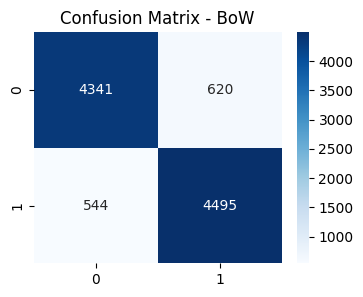

In [9]:
vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

lr_bow = LogisticRegression(max_iter=2000)
lr_bow.fit(X_train_bow, y_train)

y_pred_bow = evaluate_and_plot(lr_bow, X_test_bow, y_test, "BoW")


# **TF-IDF**

Accuracy: 0.8941
Precision: 0.884466769706337
Recall: 0.908513593967057
F1-score: 0.8963289280469897


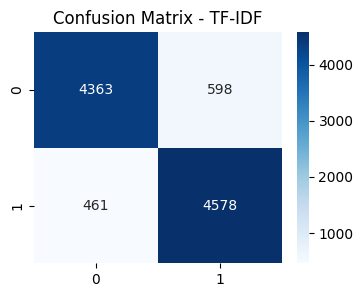

In [10]:
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

lr_tfidf = LogisticRegression(max_iter=2000)
lr_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = evaluate_and_plot(lr_tfidf, X_test_tfidf, y_test, "TF-IDF")


# **Word2Vec**

Accuracy: 0.8532
Precision: 0.8500294059988237
Recall: 0.8604881921016074
F1-score: 0.8552268244575937


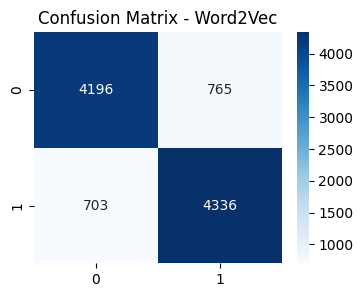

In [11]:
tokens_train = [text.split() for text in X_train]
w2v_model = Word2Vec(tokens_train, vector_size=100, window=5, min_count=2)

def get_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_train_w2v = np.array([get_vector(t.split()) for t in X_train])
X_test_w2v  = np.array([get_vector(t.split()) for t in X_test])

lr_w2v = LogisticRegression(max_iter=2000)
lr_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = evaluate_and_plot(lr_w2v, X_test_w2v, y_test, "Word2Vec")


# **GloVe**

--2025-11-15 18:55:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-15 18:55:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-15 18:55:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

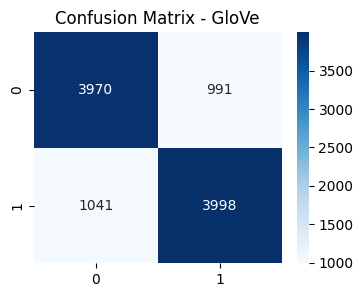

In [12]:
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -n glove.6B.zip

# Load GloVe 100d
glove_vectors = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        glove_vectors[values[0]] = np.asarray(values[1:], dtype="float32")

def get_glove_vector(tokens):
    vecs = [glove_vectors[w] for w in tokens if w in glove_vectors]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

X_train_glove = np.array([get_glove_vector(t.split()) for t in X_train])
X_test_glove  = np.array([get_glove_vector(t.split()) for t in X_test])

lr_glove = LogisticRegression(max_iter=2000)
lr_glove.fit(X_train_glove, y_train)

y_pred_glove = evaluate_and_plot(lr_glove, X_test_glove, y_test, "GloVe")


# **BERT Embeddings**

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.8415
Precision: 0.8438868976503385
Recall: 0.8410398888668387
F1-score: 0.8424609879733624


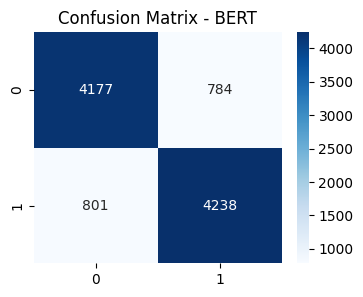

In [13]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_bert  = bert_model.encode(X_test.tolist(), show_progress_bar=True)

lr_bert = LogisticRegression(max_iter=2000)
lr_bert.fit(X_train_bert, y_train)

y_pred_bert = evaluate_and_plot(lr_bert, X_test_bert, y_test, "BERT")


# **Comparison Table**

In [14]:
comparison = pd.DataFrame({
    "Embedding": ["BoW", "TF-IDF", "Word2Vec", "GloVe", "BERT"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_bow),
        accuracy_score(y_test, y_pred_tfidf),
        accuracy_score(y_test, y_pred_w2v),
        accuracy_score(y_test, y_pred_glove),
        accuracy_score(y_test, y_pred_bert),
    ]
})

comparison


,Embedding,Accuracy
0,BoW,0.8836
1,TF-IDF,0.8941
2,Word2Vec,0.8532
3,GloVe,0.7968
4,BERT,0.8415


# **Final Conclusion**

In [15]:
print("Comparison of Embeddings:")
print(comparison)

Comparison of Embeddings:
  Embedding  Accuracy
0       BoW    0.8836
1    TF-IDF    0.8941
2  Word2Vec    0.8532
3     GloVe    0.7968
4      BERT    0.8415
